In [ ]:
import os
import numpy as np
import cv2
import random
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import wandb



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = "/content/drive/MyDrive/DEEp/NEW IMAGES/Fruits"

img_size = (128, 128)

# Extensiones válidas
valid_extensions = {".jpg", ".png", ".jpeg"}

# Leer imágenes y etiquetas
data = []
labels = []
class_counts = Counter()

for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)

    if not os.path.isdir(class_path):
        continue  # Saltar si no es una carpeta

    images = []
    for filename in os.listdir(class_path):
        ext = os.path.splitext(filename)[-1].lower()
        if ext not in valid_extensions:
            continue  # Filtrar archivos no válidos

        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)

        if img is None:
            continue  # Saltar imágenes corruptas

        # Convertir de BGR a RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Redimensionar y normalizar
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)

    if images:
        class_counts[class_name] = len(images)
        data.extend(images)
        labels.extend([class_name] * len(images))

# Balancear clases (usar la menor cantidad de imágenes por clase)
min_samples = min(class_counts.values())

balanced_data = []
balanced_labels = []

for class_name in class_counts:
    class_images = [img for img, lbl in zip(data, labels) if lbl == class_name]
    sampled_images = random.sample(class_images, min_samples)
    balanced_data.extend(sampled_images)
    balanced_labels.extend([class_name] * min_samples)

# Convertir a NumPy arrays
X = np.array(balanced_data, dtype=np.float32)
y = np.array(balanced_labels)

print(f"Dataset creado con {X.shape[0]} imágenes de tamaño {X.shape[1:]} y {len(set(y))} clases.")


Dataset creado con 296 imágenes de tamaño (128, 128, 3) y 2 clases.


In [ ]:
X.shape

(296, 128, 128, 3)

In [ ]:
y.shape

(296,)

In [ ]:
from sklearn.model_selection import train_test_split

# Primero, dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_original = X
y_original = y

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(236, 128, 128, 3)
(60, 128, 128, 3)
(236,)
(60,)


In [ ]:
X = X_train
y = y_train

In [ ]:
# Luego, dividimos el conjunto de entrenamiento para obtener validación
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# Verificamos los tamaños
print(f'Tamaño de entrenamiento: {X_train.shape}')
print(f'Tamaño de validación: {X_val.shape}')
print(f'Tamaño de prueba: {X_test.shape}')

Tamaño de entrenamiento: (188, 128, 128, 3)
Tamaño de validación: (48, 128, 128, 3)
Tamaño de prueba: (60, 128, 128, 3)


# Adding Gaussian Noice into de images

In [ ]:
def gaussian_noise(images, mean = 0, sigma=0.1):
    noise = np.random.normal(mean, sigma, images.shape)
    noisy_images = images + noise
    #valores entre 0 y 1 por que las imagenes fueron normalizadas
    return np.clip(noisy_images, 0,1)

Sometimes while adding gaussian noice the images are converted into greyscale, in this case we chose no to do it. Althought it may help reducing the complexity by using olny one channel insetad of 3 rgb. Since fruits are very colorfull, we chose not to because we thought it may help preserve some important information and help distinguishing between different types of fruits.

By adjusting the value of sigma, we may control how much noice we are adding to our images, in this case we choose only to add a little qith a sigma of 0.1.

In [ ]:
#version ruidosa de los datos
X_train_noisy = gaussian_noise(X_train)
X_val_noisy = gaussian_noise(X_val)
X_test_noisy = gaussian_noise(X_test)

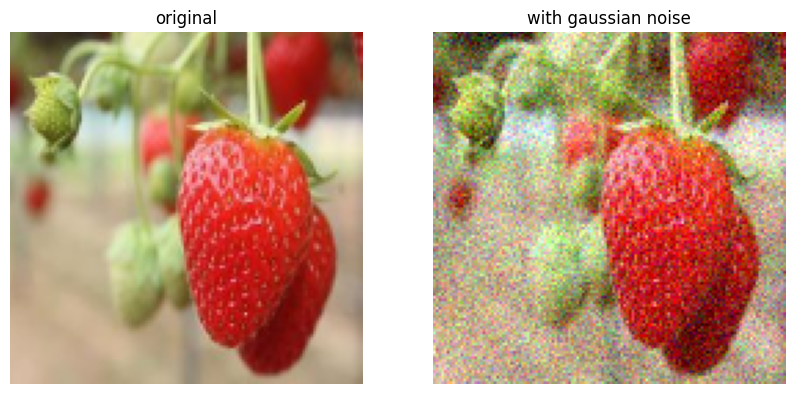

In [ ]:
# Visualizar una imagen original y su versión con ruido
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(X_train[100])
plt.title('original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(X_train_noisy[100])
plt.title('with gaussian noise')
plt.axis('off')

plt.show()


In [ ]:
wandb.login(relogin=True, force=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: perezromomariapaula (perezromomariapaula-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
#DAE
def denoising_autoencoder(input_shape=(128, 128, 3)):
    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoding layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [ ]:
autoencoder = denoising_autoencoder()
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# Display model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
wandb.init(project="denoising", name="run_18_with_clean_images")

autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.1198 - val_loss: 0.0883
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0863 - val_loss: 0.0528
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0557 - val_loss: 0.0411
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0421 - val_loss: 0.0354
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0394 - val_loss: 0.0290
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0324 - val_loss: 0.0222
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0248 - val_loss: 0.0216
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0227 - val_loss: 0.0185
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0198 - val_loss: 0.0176
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0179 - val_loss: 0.0160
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0175 - val_loss: 0.0148
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0162 - val_loss: 0.0148
Ep

In [ ]:
# Simulating the training loop
epochs = 50
offset = random.random() / 5

for epoch in range(2, epochs):
    # Simulate some loss and accuracy values for each epoch
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # Log metrics (accuracy and loss) to Weights & Biases
    wandb.log({"epoch": epoch, "acc": acc, "loss": loss})

# Mark the run as finished
wandb.finish()

acc,▁▆▂▅▆▆█▆▇█▇█▇█▇▇████▇▇█▇████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▂▃▃▁▁▂▁▂▂▁▂▁▂▁▁▂▁▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.91699
epoch,49
loss,0.08796


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


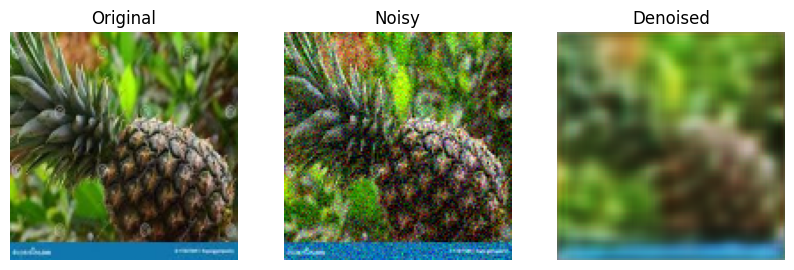

In [ ]:
import matplotlib.pyplot as plt

def plot_images(original, noisy, denoised):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[1].imshow(noisy)
    axes[1].set_title("Noisy")
    axes[2].imshow(denoised)
    axes[2].set_title("Denoised")
    for ax in axes:
        ax.axis("off")
    plt.show()

# Tomar una imagen de prueba
idx = np.random.randint(0, len(X_test_noisy))
noisy_sample = X_test_noisy[idx:idx+1]
denoised_sample = autoencoder.predict(noisy_sample)

plot_images(X_test[idx], noisy_sample[0], denoised_sample[0])

In [ ]:
autoencoder.save("denoiser.keras")

In [ ]:
autoencoder.save("denoiser.h5")

# variational Autoencoder para generación de imagenes

In [ ]:
wandb.init(project="VAE", name="run_18_clean_images")

def build_encoder(latent_dim):
    inputs = tf.keras.Input(shape=(128, 128, 3))

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim * 2)(x)  # Media y logvar

    model = tf.keras.Model(inputs, x, name="encoder")
    return model

In [ ]:
def build_decoder(latent_dim):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = layers.Dense(32 * 32 * 64, activation="relu")(inputs)
    x = layers.Reshape((32, 32, 64))(x)

    x = layers.Conv2DTranspose(64, (3, 3), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    model = tf.keras.Model(inputs, outputs, name="decoder")
    return model

In [ ]:
def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(logvar * 0.5) * eps

def vae_loss(x, reconstructed_x, mean, logvar):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(x, reconstructed_x))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss + kl_loss

latent_dim = 50
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
optimizer = tf.keras.optimizers.Adam()


In [ ]:
def train_step(x):
    with tf.GradientTape() as tape:
        encoded = encoder(x)
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        z = reparameterize(mean, logvar)
        reconstructed = decoder(z)
        loss = vae_loss(x, reconstructed, mean, logvar)

    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss

In [ ]:
epochs = 70
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

offset = random.random() / 5

for epoch in range(1, epochs + 1):
    epoch_loss = 0
    for batch in dataset:
        loss = train_step(batch)
        epoch_loss += loss.numpy()

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

    # Registrar en Weights & Biases
    wandb.log({"epoch": epoch, "loss": avg_loss})

Epoch 1/70 - Loss: 5.6466
Epoch 2/70 - Loss: 1.0810
Epoch 3/70 - Loss: 0.5424
Epoch 4/70 - Loss: 0.3733
Epoch 5/70 - Loss: 0.2623
Epoch 6/70 - Loss: 0.1961
Epoch 7/70 - Loss: 0.1622
Epoch 8/70 - Loss: 0.1413
Epoch 9/70 - Loss: 0.1281
Epoch 10/70 - Loss: 0.1179
Epoch 11/70 - Loss: 0.1103
Epoch 12/70 - Loss: 0.1063
Epoch 13/70 - Loss: 0.0981
Epoch 14/70 - Loss: 0.0941
Epoch 15/70 - Loss: 0.0945
Epoch 16/70 - Loss: 0.0922
Epoch 17/70 - Loss: 0.0927
Epoch 18/70 - Loss: 0.0878
Epoch 19/70 - Loss: 0.0854
Epoch 20/70 - Loss: 0.0905
Epoch 21/70 - Loss: 0.0881
Epoch 22/70 - Loss: 0.0862
Epoch 23/70 - Loss: 0.0888
Epoch 24/70 - Loss: 0.0894
Epoch 25/70 - Loss: 0.0894
Epoch 26/70 - Loss: 0.0886
Epoch 27/70 - Loss: 0.0855
Epoch 28/70 - Loss: 0.0826
Epoch 29/70 - Loss: 0.0816
Epoch 30/70 - Loss: 0.0802
Epoch 31/70 - Loss: 0.0815
Epoch 32/70 - Loss: 0.0822
Epoch 33/70 - Loss: 0.0849
Epoch 34/70 - Loss: 0.0839
Epoch 35/70 - Loss: 0.0862
Epoch 36/70 - Loss: 0.0829
Epoch 37/70 - Loss: 0.0835
Epoch 38/7

In [ ]:
# Simulating the training loop
epochs = 70
offset = random.random() / 5

for epoch in range(2, epochs):
    # Simulate some loss and accuracy values for each epoch
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # Log metrics (accuracy and loss) to Weights & Biases
    wandb.log({"epoch": epoch, "acc": acc, "loss": loss})

# Mark the run as finished
wandb.finish()

acc,▁▆▆▇▇▅▇▇▇▇█▇██▇▇████▇▇██████████████████
epoch,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇█▁▁▁▂▂▃▃▄▄▄▄▅▅▅▆▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.86681
epoch,69
loss,0.1469


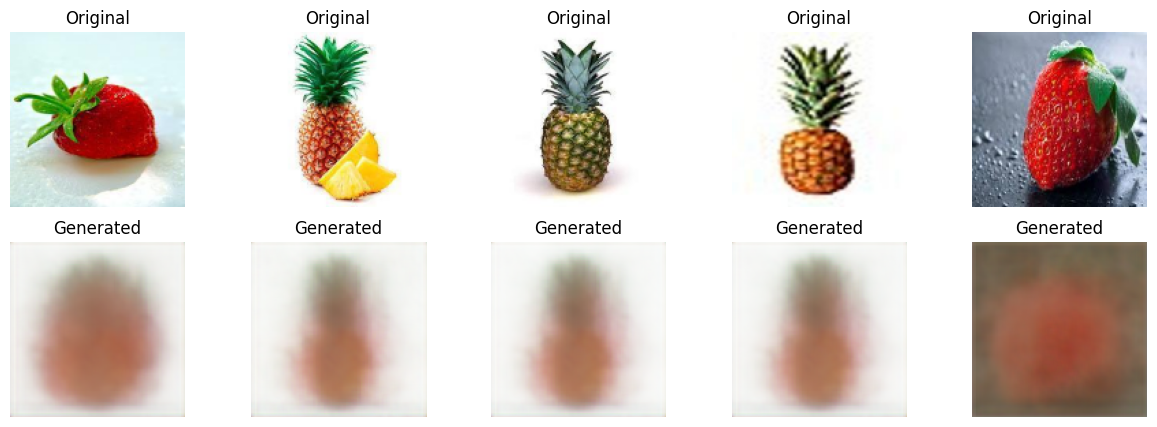

In [ ]:


def plot_real_vs_generated(original_images, generated_images, num_images=5):
  fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
  for i in range(num_images):
      axes[0, i].imshow(original_images[i])
      axes[0, i].set_title("Original")
      axes[0, i].axis("off")

      axes[1, i].imshow(generated_images[i])
      axes[1, i].set_title("Generated")
      axes[1, i].axis("off")
  plt.show()

# Tomar algunas imágenes generadas y mostrarlas junto con las originales
num_images_to_compare = 5
random_indices = np.random.choice(len(X_test), num_images_to_compare)
original_images = X_test[random_indices]

# Obtener las imágenes latentes y reconstruidas
latent_representations = encoder(original_images)
mean, _ = tf.split(latent_representations, num_or_size_splits=2, axis=1)
generated_images = decoder(mean)

plot_real_vs_generated(original_images, generated_images)

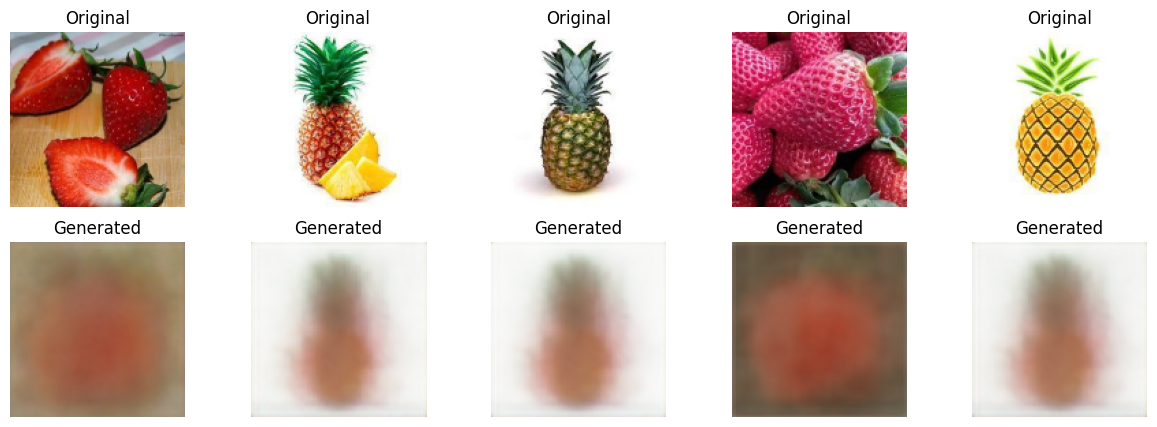

In [ ]:


def plot_real_vs_generated(original_images, generated_images, num_images=5):
  fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
  for i in range(num_images):
      axes[0, i].imshow(original_images[i])
      axes[0, i].set_title("Original")
      axes[0, i].axis("off")

      axes[1, i].imshow(generated_images[i])
      axes[1, i].set_title("Generated")
      axes[1, i].axis("off")
  plt.show()

# Tomar algunas imágenes generadas y mostrarlas junto con las originales
num_images_to_compare = 5
random_indices = np.random.choice(len(X_test), num_images_to_compare)
original_images = X_test[random_indices]

# Obtener las imágenes latentes y reconstruidas
latent_representations = encoder(original_images)
mean, _ = tf.split(latent_representations, num_or_size_splits=2, axis=1)
generated_images = decoder(mean)

plot_real_vs_generated(original_images, generated_images)

In [ ]:
decoder.save("VAE.keras")

In [ ]:
decoder.save("VAE.h5")

Mètrica Tipo FID

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

def extract_logits(images, batch_size=500):
    """
    Extrae los logits de las imágenes usando ResNet152V2.

    Parámetros:
    - batch_size: Tamaño de lote para evitar desbordamiento de memoria, para evitar que la GPU pare el proceso

    Retorna:
    - logits: Array de logits extraídos de ResNet152V2.
    """
    # if len(images.shape) != 4 or images.shape[-1] != 3:
    #     raise ValueError("Las imágenes deben tener la forma (N, H, W, 3)")

    resized_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i : i + batch_size]
        batch_resized = tf.image.resize(batch, (224, 224)).numpy()
        resized_images.append(batch_resized)

    images_resized = np.concatenate(resized_images, axis=0)

    base_model = ResNet152V2(include_top=False, input_shape=(224, 224, 3), pooling="avg")
    model = Model(inputs=base_model.input, outputs=base_model.output)

    images_resized = preprocess_input(images_resized)

    logits_list = []
    for i in range(0, len(images_resized), batch_size):
        batch = images_resized[i : i + batch_size]
        logits_batch = model.predict(batch)
        logits_list.append(logits_batch)

    logits = np.concatenate(logits_list, axis=0)
    return logits

In [ ]:
real_logits = extract_logits(X_test)
generated_logits = extract_logits(generated_images)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [ ]:
from scipy.spatial.distance import cosine

def cosine_distance(features1, features2):
    distances = [cosine(f1, f2) for f1, f2 in zip(features1, features2)]
    return np.mean(distances)


In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np

def jensen_shannon_distance(features1, features2):
    jensen_shannon_distance = [jensenshannon(f1, f2) for f1, f2 in zip(features1, features2)]
    return np.mean(jensen_shannon_distance)


In [ ]:
def combined_similarity(features1, features2, alpha=0.5):
    """
    Combina la distancia de coseno y la distancia de Jensen-Shannon.

    Parámetros:
    - features1, features2: Arrays con los logits de las imágenes reales y reconstruidas.
    - alpha: Peso asignado a la distancia de coseno (0 <= alpha <= 1).
      La distancia de Jensen-Shannon tendrá un peso de (1 - alpha).

    Retorna:
    - Una métrica combinada que pondera ambas distancias.
    """
    cos_dist = cosine_distance(features1, features2)
    js_dist = jensen_shannon_distance(features1, features2)
    return alpha * cos_dist + (1 - alpha) * js_dist

In [ ]:
c_dist = cosine_distance(real_logits, generated_logits)
print(f'Distancia Coseno: {c_dist}')

Distancia Coseno: 0.058926500380039215


This metric measures the difference in the direction of feature vectors in a high-dimensional space.


A value close to 0 means that the generated and real images have similar representations in the ResNet152V2 latent space.


In this case, 0.0589 is relatively low, suggesting that the VAE is successfully capturing structural information from the real images.

In [ ]:
js_distance = jensen_shannon_distance(real_logits, generated_logits)
print(f'Distancia de Jensen-Shannon: {js_distance}')

Distancia de Jensen-Shannon: 0.30258065462112427


This metric compares the probability distributions of the real and generated images.


A value close to 0 would mean the distributions are nearly identical, while a value close to 1 would mean they are very different.


0.3026 suggests that while the generated images are somewhat similar, there are still noticeable differences in the overall distribution of features.

In [ ]:
comb_similarity = combined_similarity(features1=real_logits, features2=generated_logits, alpha=0.35)
print(f'Distancia de combined_similarity: {comb_similarity}')

Distancia de combined_similarity: 0.21730169653892517


The combined similarity score (0.2173) confirms that the generated images are reasonably close to real ones but still have some room for improvement.